# Analysis of the compliance check

In [1]:
# %%
import sqlite3

import matplotlib.pyplot as plt
import pandas as pd
import scipy

# parameters
db_file = "../data/question_variations.db"

# Loading data

In [3]:
# %%
# connect to db
con = sqlite3.connect(db_file)
cur = con.cursor()

# Reading data
df_questions = pd.read_sql(
    "SELECT * FROM questions",
    con=con,
)
df_variations = pd.read_sql(
    "SELECT * FROM variations_evaluated",
    con=con,
)

# Analyse evaluation of variations

- in the evaluation step, the existing questions and their variations were sent to the chatbot
- the response of the chatbot was compared to the expected answer
- we distinguish different types of variations
    - existing: the existing questions (should be close to 100% correctness)
    - mistakes: small spelling mistakes in the existing questions
    - new: newly generated questions to a topic (no expected answer exists)
    - translation: english and french version of the existing questions
    - variation: slightly different formulations of the existing questions

## Overview

In [4]:
df_result = df_variations.groupby(["type"]).agg(
    N=("correct", "count"), Correct=("correct", "sum")
)
df_result["Rate"] = df_result["Correct"] / df_result["N"]
df_result

N  Correct      Rate
type                                
existing      505      500  0.990099
mistakes     1333     1262  0.946737
new           140        0  0.000000
translation  1014       44  0.043393
variation     340      248  0.729412

## By topic

In [ ]:
# %%
df_result = df_variations.groupby(["type", "topic"]).agg(
    N=("correct", "count"), Correct=("correct", "sum")
)
df_result["Rate"] = df_result["Correct"] / df_result["N"]
df_result = df_result.reset_index()
df_result = df_result[df_result["type"].isin(["mistakes", "variation"])]
df_result_wide = df_result.pivot(
    index="topic", columns="type", values=["N", "Correct", "Rate"]
)
df_result_wide.columns = [
    " ".join(col).strip() for col in df_result_wide.columns.values
]

df_result_wide.sort_values("Rate variation").reset_index()

## Relation to number of existing questions

- the chatbot is based of quick stories (slugs), which relate the questions to a predefined answer
- for each slug, multiple questions can be defined (relating to the same answer)
- it is suspected that the more (differently formulated) questions exists, the more accurate is the response in a given slug

In [ ]:
df_result = (
    df_variations[df_variations["type"].isin(["mistakes", "variation"])]
    .groupby(["type", "slug"])
    .agg(variations=("correct", "count"), Correct=("correct", "sum"))
)
df_result["Rate"] = df_result["Correct"] / df_result["variations"]

questions_count = (
    df_questions.rename({"id": "questions"}, axis=1)
    .groupby("slug")["questions"]
    .count()
)
df_result = pd.merge(df_result, questions_count, left_index=True, right_index=True)
df_result.head().reset_index()

## Plot

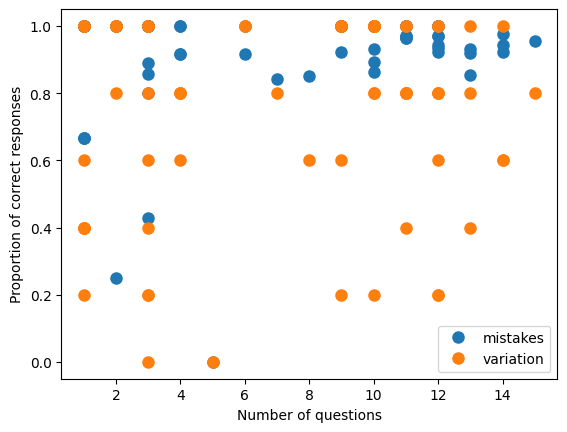

In [7]:
fig, ax = plt.subplots()
ax.margins(0.05)  # Optional, just adds 5% padding to the autoscaling
for name, group in df_result.groupby("type"):
    ax.plot(group.questions, group.Rate, marker="o", linestyle="", ms=8, label=name)
ax.legend()
plt.xlabel("Number of questions")
plt.ylabel("Proportion of correct responses")

plt.show()

## Pearson's correlation coefficient

In [8]:
scipy.stats.pearsonr(
    df_result.loc["mistakes"]["questions"], df_result.loc["mistakes"]["Rate"]
)

PearsonRResult(statistic=0.24169218114153054, pvalue=0.04707344995566136)

In [9]:
scipy.stats.pearsonr(
    df_result.loc["variation"]["questions"], df_result.loc["variation"]["Rate"]
)

PearsonRResult(statistic=0.15274427140228583, pvalue=0.21367577064031487)